# Action Balance Equation Fenics Convergence Test Notebook for Stabilized FEM

This notebook provides several numerical test cases where the convergence rates of the error in numerical solutions are tested with respect to analytic solutions. The governing equation for spectral wind wave models, the action balance equation, is considered. In all these cases, only methods that are FEM in space and finite difference in time are considered. Maybe full space-time FEM can be added later, but computational cost is prohibitive


## $\frac{\partial N}{\partial t} + \nabla \cdot \mathbf{c} N  = \frac{S(\mathbf{x}, t)}{\sigma}$


## Test 1: Propogation Test Case:

Goal: Evaluate capabilities of different FEM schemes in "pure advection" scenario
by setting source to $S$ to 0.


Setup: Harmonic wave propogating across 2D domain, c is constant in x and y:

$\frac{\partial N}{\partial t} +  \textbf{c} \cdot \nabla N = 0$

$\Omega = [0,10] \times [0,10]$

$\textbf{c} = (1 , 1)$

$N_0 = sin(x) + cos ( y)$

$N_{analytic} = sin(x - c_xt) + cos(y - c_yt)$

$N = N_{analytic}$  on $\partial \Omega$

Total time = 5

number of time steps = 1000

(time step set small so really just focusing on FEM error convergence part on this test)

## Test 2: Propogation with growth added

Goal: Similar to Test 1 but now considering growth term. Qualitatively looks kind of like a spectrum maturing. Inspired from test case from:

H. Egger, J. Schoberl, A hybrid mixed discontinuous Galerkin finite-element method for convection–diffusion241
problems, IMA Journal of Numerical Analysis 30 (4) (2010) 1206–1234.


Domain:

$\Omega = (0, L) \times (0,L)$

$L=1$

Assume:

$\textbf{c} = \{1,0\}$

$u_{exact} =  (-4(y-0.5)^2+1)\left[ x + \frac{e^{\gamma \cdot b_x \cdot x} - 1 }{1 - e^{\gamma \cdot b_x}}\right]$ 

$\gamma = 100t$

$t=[0.01,1]$

number of time steps = 1000

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial N}{\partial x}   = S(x, y, t)$

From analytic differentiation S should be:

$(-4(y-0.5)^2+1)\left[\frac{100 e^{100t}(e^{100tx} - 1)}{(1-e^{100t})^2} + \frac{100xe^{100tx}}{1-e^{100t}}\right] + (-4(y-0.5)^2+1)\left[ 1 + \frac{100t e^{\gamma \cdot b_x \cdot x} }{1 - e^{\gamma \cdot b_x}}\right]$


## Test 3: Adding non-uniform velocity field

(may still need some more work)

Domain:

$\Omega = (0, L) \times (0,L)$

$L=1$

Assume:
(trying to be like dispersion relation ($c_g = c_p = \sqrt{gh}$)

$\textbf{c} = \{ \sqrt{1+x},\sqrt{1+x}\}$

$u=e^{t}\sin(c_1\pi x)\sin(c_2\pi y)$ 



Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial N}{\partial x} + \frac{\partial N}{\partial y}  = S(x, y, t)$


## Test 4: Uniform coastline:

Assuming coast line that varies along x direction but is uniform in y, mathematically meaning:

$\frac{\partial N}{\partial y} = 0$ and $\frac{\partial c_{y}}{\partial y} = 0$

Which makes action balance equation:

$\frac{\partial N}{\partial t} + \frac{\partial c_x N}{\partial x} + \frac{\partial c_\sigma N}{\partial \sigma}+ \frac{\partial c_\theta N}{\partial \theta}  = \frac{S(\sigma, \theta, t)}{\sigma}$

In this specific script we will perform the test as seen in ONR test bed case A21

## Case A21

"An infinitely long plane beach with parallel depth contours (slope 1:200) is considered. The x-axis is normal to the depth contours (see Figure 7). At a water depth of 20m, monochromatic, uni- directional waves enter the model area. At the up-wave boundary the incoming waves propagate at an angle of 0° relative to the positive x-axis. The distance of the up-wave boundary to the waterline is 4000 m. The incident wave height Hi and period Ti are 1 m and 10 s respectively.
Ambient currents and wind are absent."

## Conditions
In the SWAN computation this harmonic wave is simulated with a Gaussian-shaped frequency spectrum with peak
frequency 0.1 Hz, standard deviation 0.01 Hz, and a resolution
of 3% of the frequency (diffusion in frequency space does not
occur as $c_{\sigma}$= 0 in this case, and the frequency resolution may
therefore be somewhat coarse). The long crestedness in this
computation is simulated with a $cos^{500} (\theta)$ directional distribution (the directional width $\sigma_{\theta} = 2.5 $ degrees, where su is the standard
deviation of the directional distribution



## Solution

$\frac{H^2}{H_i^2}=\frac{c_{g,i}cos(\theta_i)}{c_g cos(\theta)}$

Where $H_i$ , $c_{g,i}$, $\theta_i$ is the boundary condition that remains steady through time


## Weak Forms:

### Discontinuous Galerkin

### Least Squares

### SUPG

### Galerkin

### SUPG with DG elements


In [1]:
#import any necessary libraries in this block
from __future__ import print_function
from fenics import *
from ufl import nabla_div
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#define global variables
g=9.81

In [4]:
#User input for simulations

#you can either just pick one config to run, or do a comparitive study where
#at most, one of following: weak_form,p_type,pq_degree, and nx may be longer than 1 and that many sims will be run
#Example: want to do convergence analysis for error when refining mesh with least squares:
#weak_form=['LSQ']
#p_type = ['P']
#pq_degree = [1]
#nx = [2,4,8,16,32,64]
#this will run sim and calculate all errors for each level of refinement nx



#pick test case number (currently 1 through 4 available)
test_case_no=4
#pick weak form to test by entering list of following strings
#currently available: LSQ, DG, SUPG, Galerkin, SUPGDG
weak_form=['LSQ']
#pick function space corresponding to each weak form by entering list of strings
#some examples are: CG, P , DG
p_type=['P']
#pick polynomial degree, list of ints
pq_degree = [1]
# number of elements in a given direction
nx = [20]

## Run Simulation(s)


In [5]:
l_inf,l2_err,u_final,lat_coords=run_sim(test_case_no,weak_form,p_type,pq_degree,nx)


Calling FFC just-in-time (JIT) compiler, this may take some time.


## Post-Processing

In [6]:
if test_case_no != 4:
    p=plot(u_final)
    plt.colorbar(p)

In [7]:
if test_case_no != 4:
    plt.plot(l2_err)

In [8]:
if test_case_no != 4:
    plt.plot(l_inf)

In [9]:
if test_case_no != 4:
    print('Initial L-inf error')
    print(l_inf[0])
    print('Final L-inf error')
    print(l_inf[-1])
    print('Max L-inf error')
    print(np.amax(l_inf))
    print('Initial L-2 error')
    print(l2_err[0])
    print('Final L-2 error')
    print(l2_err[-1])
    print('Max L-2 error')
    print(np.amax(l2_err))

0.0
39.5
79.0
118.5
158.0
197.5
237.0
276.5
316.0
355.5
395.0
434.5
474.0
513.5
553.0
592.5
632.0
671.5
711.0
750.5
790.0
829.5
869.0
908.5
948.0
987.5
1027.0
1066.5
1106.0
1145.5
1185.0
1224.5
1264.0
1303.5
1343.0
1382.5
1422.0
1461.5
1501.0
1540.5
1580.0
1619.5
1659.0
1698.5
1738.0
1777.5
1817.0
1856.5
1896.0
1935.5
1975.0
2014.5
2054.0
2093.5
2133.0
2172.5
2212.0
2251.5
2291.0
2330.5
2370.0
2409.5
2449.0
2488.5
2528.0
2567.5
2607.0
2646.5
2686.0
2725.5
2765.0
2804.5
2844.0
2883.5
2923.0
2962.5
3002.0
3041.5
3081.0
3120.5
3160.0
3199.5
3239.0
3278.5
3318.0
3357.5
3397.0
3436.5
3476.0
3515.5
3555.0
3594.5
3634.0
3673.5
3713.0
3752.5
3792.0
3831.5
3871.0


3910.5
3950.0
['YP', 'Hs', 'Dir', 'Dep', 'K', 'Cg', 'C']


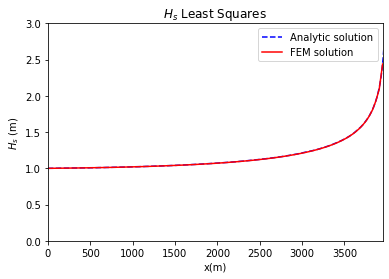

In [13]:
if test_case_no==4:
    Hs_vec=np.zeros(len(lat_coords))
    i=0
    #calc Hs at each point in physical space
    m_1D=IntervalMesh(30,0.25,2.0)
    V_1D=FunctionSpace(m_1D, "CG",1)
    i=0
    for lat in lat_coords:
        print(lat)

        test1=my1DExpression(u_final,x=lat)
        Uy=interpolate(test1,V_1D)
        intUy=4*np.sqrt(assemble(Uy*dx))
        Hs_vec[i]=intUy
        i=i+1
    
    #attempt to read in analytic
    fname='Shoaling_Analytic.txt'
    f=open(fname,"r")
    lines=f.readlines()
    f.close()
    column_names=lines[0].split()
    print(column_names)
    A=np.zeros((999,len(column_names))) #should be 1000, but last row is garbage
    ctr=0
    for line in lines[2:-1]:
        A[ctr,:]=line.split()
        ctr+=1

    #now plot
    plt.plot(A[:,0],A[:,1],'b--',label='Analytic solution')

    plt.plot(lat_coords[:],Hs_vec[:],'r',label='FEM solution')
    plt.title('$H_s$ Least Squares')
    plt.xlim((0,3950))
    plt.ylim((0,3))
    plt.xlabel('x(m)')
    plt.ylabel('$H_s$ (m)')
    plt.legend()
    #plt.savefig('CaseA21_LSQ.png')
    

In [11]:
if test_case_no==2:
    mesh = RectangleMesh(Point(0.0,0.0),Point(1.0,1.0),50,50)
    u_D = Expression('(-4*pow(x[1]-0.5,2)+1)*(x[0] + (exp(gamma*t*c_sigma*x[0]) -1 )/(1-exp(gamma*t*c_sigma)))',
                 degree=4, c_sigma=1,gamma=100,t=0.01,domain=mesh)

    p=plot(u_D,mesh=mesh)
    plt.colorbar(p)